In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
import requests
from datetime import datetime

In [59]:
dfn = pd.read_csv("realtor.csv")

/var/folders/zj/ynzvcmrn353gts4xls46gb7c0000gn/T/ipykernel_86487/4017938698.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfn = pd.read_csv("realtor.csv")


In [60]:
df=dfn.copy()

In [61]:
# could automate via selenium if needed, for now need to manually download

#df = pd.read_csv('../../Data/data_lake_raw/RDC_Inventory_Core_Metrics_Zip_History.csv').iloc[:-1]

df = df.drop(df.filter(regex='_yy$|_mm$', axis=1).columns, axis=1)

In [62]:
df.shape

(2521569, 16)

In [63]:
data_types = df.dtypes

empty_values_count = df.isnull().sum()

empty_values_percent = (empty_values_count / len(df)) * 100

result = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': data_types.values,
    'Empty Values Count': empty_values_count.values,
    'Empty Values Percent': empty_values_percent.values
})

result

,Column Name,Data Type,Empty Values Count,Empty Values Percent
0,month_date_yyyymm,object,0,0.000000
1,postal_code,object,0,0.000000
2,zip_name,object,71052,2.817769
3,median_listing_price,float64,7073,0.280500
4,active_listing_count,float64,4731,0.187621
5,median_days_on_market,float64,25934,1.028487
6,new_listing_count,float64,3280,0.130078
7,price_increased_count,float64,3280,0.130078
8,price_reduced_count,float64,3280,0.130078
9,pending_listing_count,float64,563363,22.341764


The cell below will replace the empty values with yearly avgs, we can change the logic later if we need to.

For the remaining columns I removed the rows with empty values, again we can chg this logic later

In [64]:
# Filter out rows where 'month_date_yyyymm' does not conform to the 'YYYYMM' format
# Assuming all valid dates have a length of 6 characters (e.g., '202311')
df = df[df['month_date_yyyymm'].astype(str).str.len() == 6]

# Convert the column to datetime and extract the year
df['year'] = pd.to_datetime(df['month_date_yyyymm'], format='%Y%m').dt.year



In [65]:

missing_data_total_counts = df.groupby(['year', 'postal_code']).apply(lambda group: group.isna().sum().sum())
missing_data_total_counts = missing_data_total_counts.reset_index(name='total_missing_count')

data_types = df.dtypes
empty_values_count = df.isnull().sum()
empty_values_percent = (empty_values_count / len(df)) * 100

missing_data_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': data_types.values,
    'Empty Values Count': empty_values_count.values,
    'Empty Values Percent': empty_values_percent.values
})

columns_to_replace = missing_data_info[missing_data_info['Empty Values Percent'] > 20]['Column Name']

for column in columns_to_replace:
    year_avg = df.groupby('year')[column].transform('mean')
    df[column] = df[column].fillna(year_avg)


df_cleaned = df.copy(deep=True)

df_cleaned.dropna(subset=df.columns.difference(columns_to_replace), inplace=True)

df_cleaned.head()

,month_date_yyyymm,postal_code,zip_name,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count,pending_ratio,quality_flag,year
0,202311,11949,"manorville, ny",644500.0,68.0,56.0,18.0,0.0,8.0,10.000000,293.0,2376.0,672295.0,78.0,0.147100,1.0,2023
1,202311,35980,"horton, al",394950.0,6.0,72.0,2.0,0.0,4.0,1.000000,157.0,2074.0,387017.0,7.0,0.166700,0.0,2023
2,202311,22643,"markham, va",735000.0,3.0,30.0,0.0,0.0,0.0,0.000000,328.0,2531.0,761667.0,3.0,0.000000,0.0,2023
3,202311,26587,"rachel, wv",195000.0,0.0,51.0,0.0,0.0,0.0,17.079545,111.0,1750.0,195000.0,0.0,0.844677,1.0,2023
4,202311,61360,"seneca, il",269800.0,7.0,64.0,0.0,0.0,2.0,1.000000,147.0,2045.0,495900.0,8.0,0.142900,0.0,2023


In [66]:
df_cleaned.shape

missing_data_total_counts = df_cleaned.groupby(['year', 'postal_code']).apply(lambda group: group.isna().sum().sum())
missing_data_total_counts = missing_data_total_counts.reset_index(name='total_missing_count')

data_types = df_cleaned.dtypes
empty_values_count = df_cleaned.isnull().sum()
empty_values_percent = (empty_values_count / len(df_cleaned)) * 100

missing_data_info_post_clean = pd.DataFrame({
    'Column Name': df_cleaned.columns,
    'Data Type': data_types.values,
    'Empty Values Count': empty_values_count.values,
    'Empty Values Percent': empty_values_percent.values
})

missing_data_info_post_clean

,Column Name,Data Type,Empty Values Count,Empty Values Percent
0,month_date_yyyymm,object,0,0.0
1,postal_code,object,0,0.0
2,zip_name,object,0,0.0
3,median_listing_price,float64,0,0.0
4,active_listing_count,float64,0,0.0
5,median_days_on_market,float64,0,0.0
6,new_listing_count,float64,0,0.0
7,price_increased_count,float64,0,0.0
8,price_reduced_count,float64,0,0.0
9,pending_listing_count,float64,0,0.0


In [67]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()

def dtype_to_sql(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_object_dtype(dtype):
        return 'TEXT'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TIMESTAMP'
    else:
        return 'TEXT'

create_table_query = f"""
CREATE TABLE IF NOT EXISTS Realtor (
    month_date_yyyymm INTEGER NOT NULL,
    postal_code TEXT NOT NULL,
    zip_name TEXT,
    median_listing_price REAL,
    active_listing_count REAL,
    median_days_on_market REAL,
    new_listing_count REAL,
    price_increased_count REAL,
    price_reduced_count REAL,
    pending_listing_count REAL,
    median_listing_price_per_square_foot REAL,
    median_square_feet REAL,
    average_listing_price REAL,
    total_listing_count REAL,
    pending_ratio REAL,
    quality_flag REAL,
    year INTEGER NOT NULL,
    PRIMARY KEY (month_date_yyyymm, postal_code)
);

"""

cursor.execute(create_table_query)
conn.commit()
conn.close()

In [68]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()

def dtype_to_sql(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_object_dtype(dtype):
        return 'TEXT'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TIMESTAMP'
    else:
        return 'TEXT'

df_cleaned.to_sql(
    'Realtor',
    conn,
    if_exists='replace',
    index=False,
    dtype={col: dtype_to_sql(dtype) for col, dtype in zip(df_cleaned.columns, df_cleaned.dtypes)}
)

conn.commit()
conn.close()

In [69]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()

API_KEY = '6bf8895c846d89aeaec6a40b739746ce'

endpoint = 'https://api.stlouisfed.org/fred/series/observations'

series_ids = ['CPIAUCSL', 'FEDFUNDS', 'UMCSENT', 'RSXFS', 'UNRATE', 'DGS10','M2','BOPGSTB','HOUST','PI']

conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()


def create_table_for_series(series_id, cursor):
    cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS {series_id} (
        date INTEGER PRIMARY KEY,
        value REAL
    )
    ''')
    conn.commit()

def convert_date_format(date_str):
    return int(datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y%m'))

for series_id in series_ids:
    response = requests.get(endpoint, params={
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json'
    })
    data = response.json()

    df = pd.DataFrame(data['observations'])

    df['date'] = df['date'].apply(convert_date_format)

    create_table_for_series(series_id, cursor)

    df.to_sql(series_id, conn, if_exists='replace', index=False, dtype={
        'date': 'INTEGER',
        'value': 'REAL'
    })


cursor.close()
conn.close()

In [70]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()


df_test = pd.read_sql('select * from Realtor', conn)


cursor.close()
conn.close()


df_test


,month_date_yyyymm,postal_code,zip_name,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count,pending_ratio,quality_flag,year
0,202311,11949,"manorville, ny",644500.0,68.0,56.0,18.0,0.0,8.0,10.000000,293.0,2376.0,672295.0,78.0,0.147100,1.0,2023
1,202311,35980,"horton, al",394950.0,6.0,72.0,2.0,0.0,4.0,1.000000,157.0,2074.0,387017.0,7.0,0.166700,0.0,2023
2,202311,22643,"markham, va",735000.0,3.0,30.0,0.0,0.0,0.0,0.000000,328.0,2531.0,761667.0,3.0,0.000000,0.0,2023
3,202311,26587,"rachel, wv",195000.0,0.0,51.0,0.0,0.0,0.0,17.079545,111.0,1750.0,195000.0,0.0,0.844677,1.0,2023
4,202311,61360,"seneca, il",269800.0,7.0,64.0,0.0,0.0,2.0,1.000000,147.0,2045.0,495900.0,8.0,0.142900,0.0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082348,201707,51026,"hornick, ia",84900.0,4.0,96.0,4.0,0.0,0.0,18.638962,53.0,1786.0,89150.0,4.0,0.408217,1.0,2017
2082349,201707,31549,"lumber city, ga",64900.0,5.0,114.0,0.0,0.0,0.0,18.638962,47.0,1512.0,81159.0,5.0,0.408217,0.0,2017
2082350,201707,50157,"malcom, ia",137450.0,4.0,93.0,0.0,0.0,0.0,18.638962,114.0,1511.0,182450.0,4.0,0.408217,1.0,2017
2082351,201707,29916,"early branch, sc",350000.0,3.0,323.0,0.0,0.0,0.0,1.000000,150.0,2800.0,925000.0,4.0,0.333300,1.0,2017


In [71]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()

# Drop the existing view if it exists
cursor.execute("DROP VIEW IF EXISTS Realtor_Final_Merged")


cursor.execute("""
CREATE VIEW Realtor_Final_Merged AS
SELECT
    r.*,
    CPIAUCSL.value AS CPIAUCSL_value,
    FEDFUNDS.value AS FEDFUNDS_value,
    UMCSENT.value AS UMCSENT_value,
    RSXFS.value AS RSXFS_value,
    UNRATE.value AS UNRATE_value,
    DGS10.value AS DGS10_value,
    M2.value AS M2_value,
    BOPGSTB.value AS BOPGSTB_value,
    HOUST.value AS HOUST_value,
    PI.value AS PI_value
FROM
    Realtor r
    INNER JOIN CPIAUCSL ON r.month_date_yyyymm = CPIAUCSL.date
    INNER JOIN FEDFUNDS ON r.month_date_yyyymm = FEDFUNDS.date
    INNER JOIN UMCSENT ON r.month_date_yyyymm = UMCSENT.date
    INNER JOIN RSXFS ON r.month_date_yyyymm = RSXFS.date
    INNER JOIN UNRATE ON r.month_date_yyyymm = UNRATE.date
    INNER JOIN DGS10 ON r.month_date_yyyymm = DGS10.date
    INNER JOIN M2 ON r.month_date_yyyymm = M2.date
    INNER JOIN BOPGSTB ON r.month_date_yyyymm = BOPGSTB.date
    INNER JOIN HOUST ON r.month_date_yyyymm = HOUST.date
    INNER JOIN PI ON r.month_date_yyyymm = PI.date
;
""")

conn.commit()

conn.close()


In [72]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()

# Verify the columns in the Realtor table
cursor.execute('PRAGMA table_info(Realtor_Final_Merged);')
columns_info = cursor.fetchall()

for col in columns_info:
    print(col)

cursor.close()
conn.close()


(0, 'month_date_yyyymm', 'TEXT', 0, None, 0)
(1, 'postal_code', 'TEXT', 0, None, 0)
(2, 'zip_name', 'TEXT', 0, None, 0)
(3, 'median_listing_price', 'REAL', 0, None, 0)
(4, 'active_listing_count', 'REAL', 0, None, 0)
(5, 'median_days_on_market', 'REAL', 0, None, 0)
(6, 'new_listing_count', 'REAL', 0, None, 0)
(7, 'price_increased_count', 'REAL', 0, None, 0)
(8, 'price_reduced_count', 'REAL', 0, None, 0)
(9, 'pending_listing_count', 'REAL', 0, None, 0)
(10, 'median_listing_price_per_square_foot', 'REAL', 0, None, 0)
(11, 'median_square_feet', 'REAL', 0, None, 0)
(12, 'average_listing_price', 'REAL', 0, None, 0)
(13, 'total_listing_count', 'REAL', 0, None, 0)
(14, 'pending_ratio', 'REAL', 0, None, 0)
(15, 'quality_flag', 'REAL', 0, None, 0)
(16, 'year', 'INTEGER', 0, None, 0)
(17, 'CPIAUCSL_value', 'REAL', 0, None, 0)
(18, 'FEDFUNDS_value', 'REAL', 0, None, 0)
(19, 'UMCSENT_value', 'REAL', 0, None, 0)
(20, 'RSXFS_value', 'REAL', 0, None, 0)
(21, 'UNRATE_value', 'REAL', 0, None, 0)
(22, 'D

In [73]:
conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()


df_test = pd.read_sql('select * from CPIAUCSL where date >201600', conn)


cursor.close()
conn.close()


df_test

,realtime_start,realtime_end,date,value
0,2023-12-02,2023-12-02,201601,237.652
1,2023-12-02,2023-12-02,201602,237.336
2,2023-12-02,2023-12-02,201603,238.080
3,2023-12-02,2023-12-02,201604,238.992
4,2023-12-02,2023-12-02,201605,239.557
...,...,...,...,...
89,2023-12-02,2023-12-02,202306,303.841
90,2023-12-02,2023-12-02,202307,304.348
91,2023-12-02,2023-12-02,202308,306.269
92,2023-12-02,2023-12-02,202309,307.481


In [74]:
# DO NOT RUN


# conn = sqlite3.connect('HOUSING.db')
# cursor = conn.cursor()

# cursor.execute("SELECT name, type FROM sqlite_master WHERE type IN ('table','view')")
# tables_and_views = cursor.fetchall()

# for name, type in tables_and_views:
#     sql = f"DROP {type} IF EXISTS {name}"
#     cursor.execute(sql)

# conn.commit()
# cursor.close()
# conn.close()

# print("All tables and views have been dropped.")

In [75]:
import pandas as pd
import numpy as np
import sqlite3
import logging

In [76]:
import logging
import sqlite3
import pandas as pd

logging.basicConfig(filename='logs.log', level=logging.DEBUG, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

conn = sqlite3.connect('HOUSING.db')
cursor = conn.cursor()

chunk_size = 10000  

chunks = []
query = "SELECT FEDFUNDS_value, year, median_days_on_market FROM Realtor_Final_Merged"
for chunk in pd.read_sql(query, conn, chunksize=chunk_size):
    chunks.append(chunk)

df_partial = pd.concat(chunks, ignore_index=True)


cursor.close()
conn.close()

df_partial.head()


,FEDFUNDS_value,year,median_days_on_market
0,0.08,2021,51.0
1,0.08,2021,51.0
2,0.08,2021,51.0
3,0.08,2021,51.0
4,0.08,2021,51.0


In [77]:
df_partial.shape

(112062027, 3)

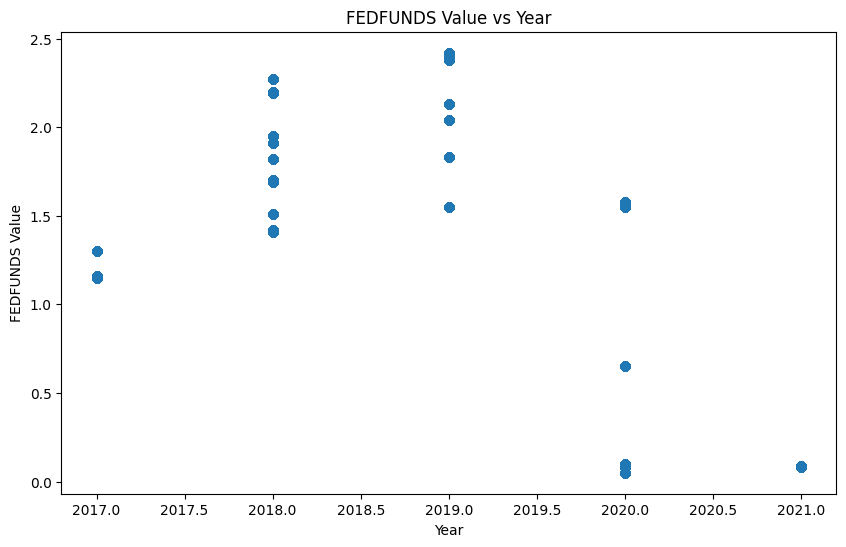

In [78]:
import matplotlib.pyplot as plt

# Plot FEDFUNDS_value vs year
plt.figure(figsize=(10, 6))
plt.scatter(df_partial['year'], df_partial['FEDFUNDS_value'])
plt.title('FEDFUNDS Value vs Year')
plt.xlabel('Year')
plt.ylabel('FEDFUNDS Value')
plt.show()



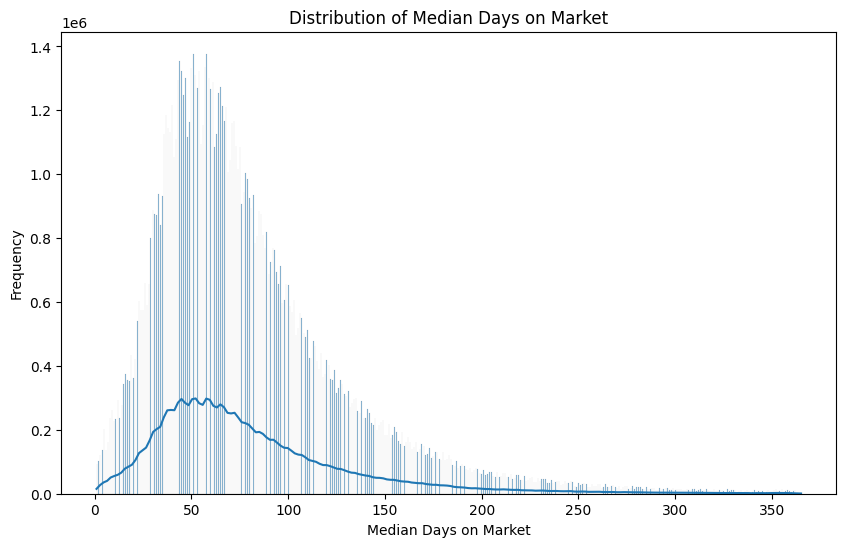

In [79]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df_partial['median_days_on_market'], kde=True)
plt.title('Distribution of Median Days on Market')
plt.xlabel('Median Days on Market')
plt.ylabel('Frequency')
plt.savefig('Dist.png')
plt.show()

/var/folders/zj/ynzvcmrn353gts4xls46gb7c0000gn/T/ipykernel_86487/1792850824.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucketed_avg = df_partial.groupby('median_days_on_market_buckets')['FEDFUNDS_value'].mean()


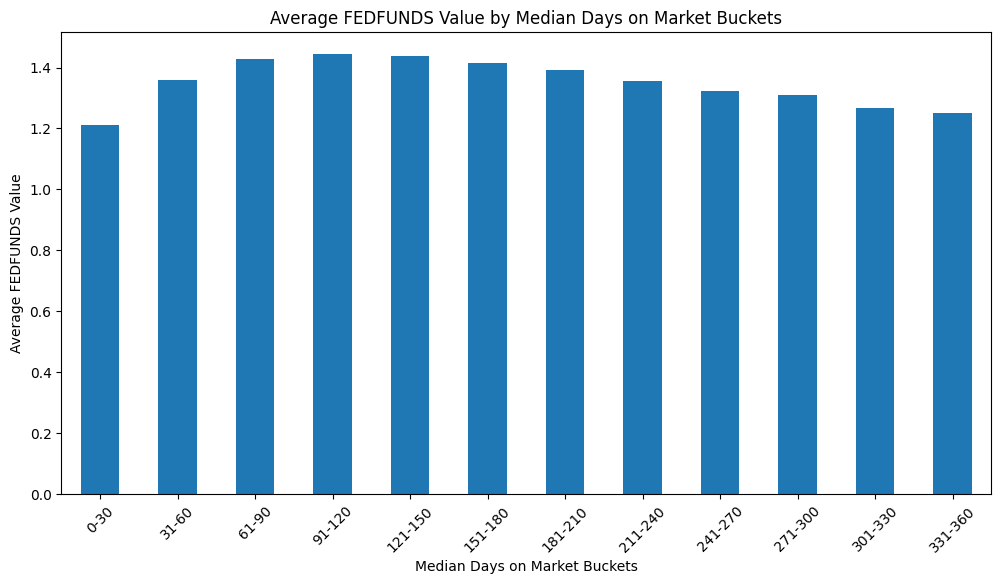

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# buckets for 'median_days_on_market'
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240', '241-270', '271-300', '301-330', '331-360']
df_partial['median_days_on_market_buckets'] = pd.cut(df_partial['median_days_on_market'], bins=bins, labels=labels, right=False)

# Grouping
bucketed_avg = df_partial.groupby('median_days_on_market_buckets')['FEDFUNDS_value'].mean()


plt.figure(figsize=(12, 6))
bucketed_avg.plot(kind='bar')
plt.title('Average FEDFUNDS Value by Median Days on Market Buckets')
plt.xlabel('Median Days on Market Buckets')
plt.ylabel('Average FEDFUNDS Value')
plt.xticks(rotation=45)
plt.show()
